In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install geopandas
import pandas as pd
import geopandas as gpd
import numpy as np

     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 6.3 MB 40.7 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 


In [4]:
ROOT_FOLDER = '/content/drive/MyDrive/'

In [5]:
# data is now our pandas DataFrame containing all of the data from our csv file
df = pd.read_csv(ROOT_FOLDER + "eviction_with_census_tract.csv",index_col=0)

# Clean Data

In [ ]:
# .head() just gives us a preview of the top rows of our dataframe, we can pass in an integer to
#  tell it how many rows we would like to see, but the default is 5
df

,Unnamed: 0.1,Join_Count,TARGET_FID,Loc_name,Status,Score,Match_type,Match_addr,User_fld,Addr_type,ARC_Street,ARC_City,ARC_State,ARC_ZIP,case_numbe,court_divi,file_date,initiating,property_a,property_1,property_2,property_3,mapc_id,muni_id,muni,parloc_id,poly_typ,map_num,mappar_id,loc_id_cnt,land_value,bldg_value,othr_value,total_valu,ls_price,ls_date,bldg_area,res_area,luc_1,luc_2,...,owner_addr,owner_city,owner_stat,owner_zip,fy,lot_areaft,far,pct_imperv,pct_bldg,pct_pave,landv_pac,bldgv_psf,totv_pac,bldlnd_rat,sqm_imperv,sqm_bldg,sqm_pave,realesttyp,temp,st_area_sh,st_length_,geometry,CoreName,CleanName,Corp,EntityName,DataID,FEIN,Owner_Groups_All,Only_Groups,index_right,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
0,0,1,0,MAD_ADDR_POST,M,92.63,A,"159 BROOKLINE ROAD 8, TOWNSEND, MA, 01469",NaN,PointAddress,159 Brookline Road 5,Townsend,MA,1469.0,2048SU000012,ayer district,2020-11-10,Summary Process - Residential (c239),Townsend,MA,159 Brookline Road 5,1469.0,821985,299,Townsend,M_185312_938643,FEE,38,38 9 0,1,83300.0,563900.0,3700.0,650900.0,195500.0,20090831.0,4458.0,4458.0,301,301,...,15 SCALES LANE,TOWNSEND,MA,01469,2019,1.000173e+05,0.044572,31.934645,4.924409,27.010236,3.627919e+04,126.491700,2.834829e+05,6.813926,2967.338976,457.571717,2509.767258,8.0,0.0,9291.917091,436.954349,POINT (185305.2413596544 938650.9030090374),KING DANA,KING DANA,False,NaN,NaN,NaN,KING DANA,NaN,1171.0,25.0,17.0,301101.0,1400000US25017301101,2.501730e+10,3011.01,CT,44272760.0,54203.0
1,1,1,1,MAD_ADDR_POST,M,97.89,A,"21 SCHOOL STREET 3, ATTLEBORO, MA, 02703",NaN,PointAddress,21 School Street Apt 3,Attleboro,MA,2703.0,2034SU000044,attleboro district,2020-11-13,Summary Process - Residential (c239),Attleboro,MA,21 School Street Apt 3,2703.0,51329,16,Attleboro,M_218112_854353,FEE,39,39_181,1,70100.0,255000.0,0.0,325100.0,350500.0,20101018.0,6285.0,4680.0,1110,1110,...,32 STATION ST,SHARON,MA,02067,2019,2.578051e+03,2.437888,98.803573,71.631631,27.171941,1.184443e+06,40.572792,5.493047e+06,3.637660,236.643156,171.563992,65.079165,3.0,0.0,239.509129,65.749524,POINT (218112.614739474 854353.7222426279),TRUXTON RONALD D AND AHUVA F,TRUXTON RONALD D AND AHUVA F,False,NaN,NaN,NaN,TRUXTON RONALD D AND AHUVA F,NaN,389.0,25.0,5.0,631600.0,1400000US25005631600,2.500563e+10,6316.00,CT,1571486.0,23449.0
2,2,1,2,MAD_ADDR_POST,M,100.00,M,"171 ROUTE 6A, SANDWICH, MA, 02563",NaN,PointAddress,171 ROUTE 6A,SANDWICH,MA,2563.0,2025SU000057,barnstable district,2020-11-09,Summary Process - Residential (c239),Sandwich,MA,"171 Route 6A, Room 1 (Upstairs)",2563.0,2022847,261,Sandwich,F_932826_2736632,FEE,66,66-030-,1,116000.0,133400.0,5300.0,254700.0,300000.0,20041006.0,0.0,1346.0,101,101,...,171 ROUTE 6A,SANDWICH,MA,02563,2011,1.233307e+04,0.109137,18.775621,10.928205,7.847415,4.097081e+05,99.108470,8.995918e+05,1.195690,215.127232,125.213147,89.914085,1.0,0.0,1145.778535,171.797499,POINT (284312.402709826 834112.9964528072),DELLEA SUSAN A,DELLEA SUSAN A,False,NaN,NaN,NaN,DELLEA SUSAN A,NaN,57.0,25.0,1.0,13300.0,1400000US25001013300,2.500101e+10,133.00,CT,12813860.0,1665619.0
3,3,1,3,MAD_ADDR_POST,M,90.53,A,"10 THACHER BROOK CIRCLE 8, ATTLEBORO, MA, 02703",NaN,PointAddress,10 Thacher Brook Circle Apt 3,Attleboro,MA,2703.0,2034SU000043,attleboro district,2020-11-12,Summary Process - Residential (c239),Attleboro,MA,10 Thacher Brook Circle Apt 3,2703.0,58944,16,Attleboro,M_218630_853510,TAX,53,NaN,1,2722000.0,13018200.0,431300.0,16171500.0,0.0,19850101.0,12204.0,11110.0,000,000,...,7 WELLS AVE SUITE 14,NEWTON,MA,02459,2019,1.202846e+06,0.010146,26.128661,7.213033,18.915628,9.857484e+04,1066.715831,5.856367e+05,4.941036,29198.248811,8060.417943,21137.830868,0.0,0.0,111748.020917,2501.159490,POINT (218724.8575637158 853790.9962384583),ETON THAMES,ETON THAMES ASSOCIATION LIMITED,True,ETON THAMES ASSOCIATES LIMITED PARTNERSHIP,00ec9c,L86003423,00ec9c,NaN,390.0,25.0,5.0,631800.0,1400000US25005631800,2.500563e+10,6318.00,CT,12001536.0,305704.0
4,4,1,4,MAD_ADDR_

In [ ]:
#Identify  not useful or duplicated columns and which column is important
#show columns
df.columns

Index(['Unnamed: 0.1', 'Join_Count', 'TARGET_FID', 'Loc_name', 'Status',
       'Score', 'Match_type', 'Match_addr', 'User_fld', 'Addr_type',
       'ARC_Street', 'ARC_City', 'ARC_State', 'ARC_ZIP', 'case_numbe',
       'court_divi', 'file_date', 'initiating', 'property_a', 'property_1',
       'property_2', 'property_3', 'mapc_id', 'muni_id', 'muni', 'parloc_id',
       'poly_typ', 'map_num', 'mappar_id', 'loc_id_cnt', 'land_value',
       'bldg_value', 'othr_value', 'total_valu', 'ls_price', 'ls_date',
       'bldg_area', 'res_area', 'luc_1', 'luc_2', 'luc_adj_1', 'luc_adj_2',
       'num_units', 'units_est', 'units_src', 'num_rooms', 'yr_built',
       'site_addr', 'addr_str', 'addr_num', 'addr_zip', 'owner_name',
       'owner_addr', 'owner_city', 'owner_stat', 'owner_zip', 'fy',
       'lot_areaft', 'far', 'pct_imperv', 'pct_bldg', 'pct_pave', 'landv_pac',
       'bldgv_psf', 'totv_pac', 'bldlnd_rat', 'sqm_imperv', 'sqm_bldg',
       'sqm_pave', 'realesttyp', 'temp', 'st_area_sh',

In [6]:
#create a dataframe with useful columns
df_imp = df.filter(['muni','owner_name', 'geometry', 'Corp', 'ARC_Street', 'ARC_City', 'poly_typ',
       'ARC_State', 'ARC_ZIP', 'case_numbe', 'court_divi', 'file_date', 'num_rooms', 'yr_built', 'ls_price',
       'total_valu', 'ls_date', 'property_3', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND',
       'AWATER', 'Initiation', 'realesttyp'], axis=1)

In [ ]:
#remove NaN values from column muni 
df_imp = df_imp[df_imp['muni']. notna()]

In [ ]:
df_imp

,muni,owner_name,geometry,Corp,ARC_Street,ARC_City,poly_typ,ARC_State,ARC_ZIP,case_numbe,court_divi,file_date,num_rooms,yr_built,ls_price,total_valu,ls_date,property_3,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,realesttyp
0,Townsend,"KING, DANA",POINT (185305.2413596544 938650.9030090374),False,159 Brookline Road 5,Townsend,FEE,MA,1469.0,2048SU000012,ayer district,2020-11-10,7.0,1930,195500.0,650900.0,20090831.0,1469.0,25.0,17.0,301101.0,1400000US25017301101,2.501730e+10,3011.01,CT,44272760.0,54203.0,8.0
1,Attleboro,TRUXTON RONALD D & AHUVA F,POINT (218112.614739474 854353.7222426279),False,21 School Street Apt 3,Attleboro,FEE,MA,2703.0,2034SU000044,attleboro district,2020-11-13,18.0,1910,350500.0,325100.0,20101018.0,2703.0,25.0,5.0,631600.0,1400000US25005631600,2.500563e+10,6316.00,CT,1571486.0,23449.0,3.0
2,Sandwich,"DELLEA, SUSAN A",POINT (284312.402709826 834112.9964528072),False,171 ROUTE 6A,SANDWICH,FEE,MA,2563.0,2025SU000057,barnstable district,2020-11-09,6.0,1850,300000.0,254700.0,20041006.0,2563.0,25.0,1.0,13300.0,1400000US25001013300,2.500101e+10,133.00,CT,12813860.0,1665619.0,1.0
3,Attleboro,ETON THAMES ASSOC LTD PARTNERS,POINT (218724.8575637158 853790.9962384583),True,10 Thacher Brook Circle Apt 3,Attleboro,TAX,MA,2703.0,2034SU000043,attleboro district,2020-11-12,0.0,1967,0.0,16171500.0,19850101.0,2703.0,25.0,5.0,631800.0,1400000US25005631800,2.500563e+10,6318.00,CT,12001536.0,305704.0,0.0
4,Barnstable,"HOSTETTER, ADAM J & DANIEL C JR TRS",POINT (301074.556216199 823658.6264352691),False,75 Charles Street #2,Hyannis,FEE,MA,2601.0,2025SU000065,barnstable district,2020-11-16,8.0,1930,865000.0,274200.0,20070403.0,2601.0,25.0,1.0,15300.0,1400000US25001015300,2.500102e+10,153.00,CT,13212205.0,531166.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,Woburn,TUDOR GLEN VILLAGE INC,POINT (226147.9846521748 914257.011558391),True,111 Locust Street TH 111,Woburn,FEE,MA,1801.0,2153SU000008,woburn district,2021-01-19,0.0,1981,0.0,29471000.0,19810821.0,1801.0,25.0,17.0,333100.0,1400000US25017333100,2.501733e+10,3331.00,CT,7097763.0,34957.0,4.0
7911,Attleboro,EASTLANDE PARK CORP,POINT (212133.6071519015 849637.3732836959),True,1346 Newport Avenue E-2,Attleboro,TAX,MA,2703.0,21H83SP00255TA,southeast,2021-01-22,0.0,0,1000000.0,1739000.0,19860129.0,2703.0,25.0,5.0,631100.0,1400000US25005631100,2.500563e+10,6311.00,CT,8193706.0,152007.0,3.0
7912,Woburn,TUDOR GLEN VILLAGE INC,POINT (226147.9846521748 914257.011558391),True,111 Locust Street TH 15,Woburn,FEE,MA,1801.0,2153SU000007,woburn district,2021-01-19,0.0,1981,0.0,29471000.0,19810821.0,1801.0,25.0,17.0,333100.0,1400000US25017333100,2.501733e+10,3331.00,CT,7097763.0,34957.0,4.0
7913,Taunton,FARRELL BRUCE E TRS,POINT (232043.8016217993 845744.3341158029),False,1521 Somerset Avenue Rear 2nd f,Taunton,FEE,MA,2780.0,21H83SP00251TA,southeast,2021-01-22,0.0,1900,1.0,343900.0,20161027.0,2780.0,25.0,5.0,613902.0,1400000US25005613902,2.500561e+10,6139.02,CT,8045315.0,245448.0,3.0


In [ ]:
#look at means table
df_imp.describe().round(1)

,ARC_ZIP,num_rooms,yr_built,ls_price,total_valu,ls_date,property_3,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,ALAND,AWATER,realesttyp
count,4980.0,5016.0,5016.0,5.016000e+03,5.016000e+03,4394.0,5016.0,5016.0,5016.0,5016.0,5.016000e+03,5016.0,5016.0,5016.0,4982.0
mean,1982.2,32.0,1860.0,7.117300e+06,2.049381e+07,20041195.1,1968.0,25.0,17.2,493663.0,2.501769e+10,4936.6,6991977.8,673691.7,3.4
std,566.3,121.0,379.4,4.522842e+07,2.365568e+08,143714.1,588.5,0.0,8.8,253252.5,8.766662e+06,2532.5,17811921.0,3152151.2,2.2
min,1001.0,-1.0,0.0,-1.000000e+02,-1.000000e+00,18851213.0,0.0,25.0,1.0,100.0,2.500101e+10,1.0,76783.0,0.0,0.0
25%,1605.0,0.0,1900.0,0.000000e+00,2.464000e+05,20000601.0,1605.0,25.0,9.0,311400.0,2.500921e+10,3114.0,838713.0,0.0,2.0
50%,1960.0,8.0,1920.0,8.000000e+04,5.719000e+05,20070702.5,1952.0,25.0,17.0,541101.5,2.501738e+10,5411.0,1813518.0,55271.5,3.0
75%,2332.0,18.0,1971.0,5.766250e+05,5.371800e+06,20131113.2,2330.0,25.0,25.0,730401.0,2.502516e+10,7304.0,6145036.0,348565.8,4.0
max,21245.0,3604.0,2017.0,1.598200e+09,4.580550e+09,21030308.0,21245.0,25.0,27.0,985600.0,2.502776e+10,9856.0,503627514.0,56061159.0,12.0


Since the following columns seems to contain meaningless data less than or equal to 0. I will discard those and look at the mean again, along with the distributions.

In [ ]:
df['num_rooms'][df['num_rooms'] > 0].describe().round(1)

count    3032.0
mean       53.0
std       152.1
min         1.0
25%        10.0
50%        15.0
75%        28.2
max      3604.0
Name: num_rooms, dtype: float64

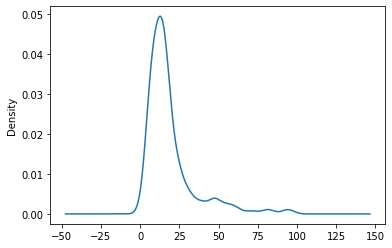

In [ ]:
df['num_rooms'][df['num_rooms'] > 0][df['num_rooms'] < 100].plot.kde()

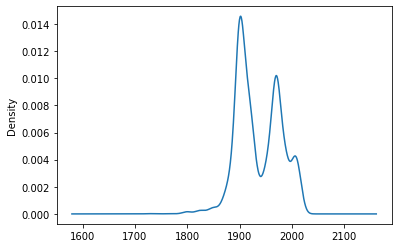

In [ ]:
df['yr_built'][df['yr_built'] > 0][df['yr_built'] < 2017].plot.kde()

In [ ]:
df['yr_built'][df['yr_built'] > 0].describe().round(1)

count    4818.0
mean     1936.4
std        42.5
min      1725.0
25%      1900.0
50%      1925.0
75%      1971.0
max      2017.0
Name: yr_built, dtype: float64

In [ ]:
df['ls_price'][df['ls_price'] > 10].describe().round(1)

count    3.084000e+03
mean     1.157600e+07
std      5.723535e+07
min      2.000000e+01
25%      1.247500e+05
50%      3.313050e+05
75%      3.050076e+06
max      1.598200e+09
Name: ls_price, dtype: float64

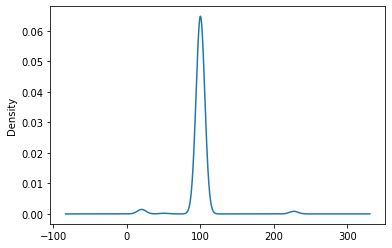

In [ ]:
df['ls_price'][df['ls_price'] > 10][df['ls_price'] < 400].plot.kde()

In [ ]:
df['property_3'][df['property_3'] > 0].describe().round(1)

count     5448.0
mean      1986.4
std        560.2
min       1001.0
25%       1605.0
50%       2019.0
75%       2339.0
max      21245.0
Name: property_3, dtype: float64

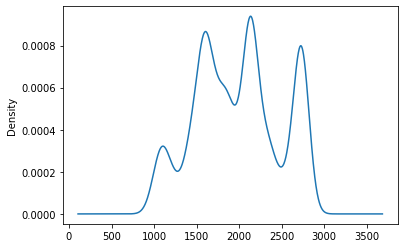

In [ ]:
df['property_3'][df['property_3'] > 0][df['property_3'] < 20000].plot.kde()

In [ ]:
df['realesttyp'][df['realesttyp'] > 0].describe().round(1)

count    4648.0
mean        3.6
std         2.1
min         1.0
25%         2.0
50%         4.0
75%         4.0
max        12.0
Name: realesttyp, dtype: float64

In [ ]:
df['realesttyp'][df['realesttyp'] > 0].median()

4.0

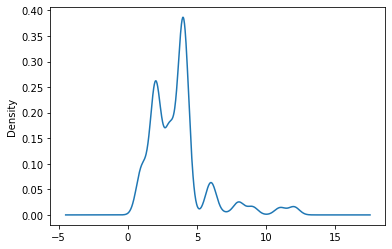

In [ ]:
df['realesttyp'][df['realesttyp'] > 0].plot.kde()

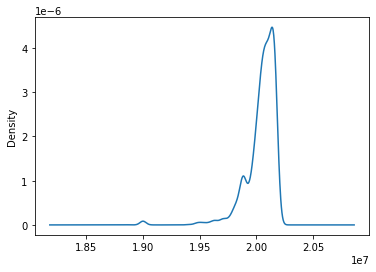

In [ ]:
df['ls_date'][df['ls_date'] > 20210000.0][df['ls_date'] < 20210000.0].plot.kde()

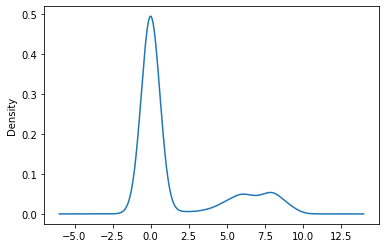

In [ ]:
ax = df_imp['num_rooms'][df_imp['num_rooms'] < 10].plot.kde()

In [ ]:
df['num_rooms'][df['num_rooms'] < 10].value_counts()

 0.0000    2459
 8.0000     168
 6.0000     147
 7.0000     103
 5.0000      87
 9.0000      67
 4.0000      34
 3.0000      15
 2.0000      15
-0.9999       7
 1.0000       5
Name: num_rooms, dtype: int64

In [ ]:
df_imp['num_rooms'][df_imp['num_rooms'] > 2000]

3212    3604.0
3228    3604.0
Name: num_rooms, dtype: float64

This is where I will value count so I can see the number of occurences of each value present in the following df columns. This will help me see what are most frequence values in each.

In [ ]:
df['ls_price'][df['ls_price'] < 2].value_counts()

 0.0000      1837
 1.0000       495
-0.9999         7
-100.0000       3
Name: ls_price, dtype: int64

In [ ]:
df['initiating'].value_counts()

Efiled SP Summons and Complaint - Non-payment of Rent                          2876
Summary Process - Residential (c239)                                            941
SP Summons and Complaint - Non-payment of Rent                                  819
Efiled SP Summons and Complaint - Cause                                         342
Efiled SP Summons and Complaint - No Cause                                      224
SP Summons and Complaint - No Cause                                             102
SP Summons and Complaint - Cause                                                 74
SP Transfer - Non-payment of Rent                                                44
Efiled SP Summons and Complaint - Foreclosure                                    38
SP Transfer- No Cause                                                            17
SP Transfer - Cause                                                              12
Public Housing Tenant Illegal Activity Declaratory Judgment (c139 &#167;19) 

In [ ]:
print(df_imp['file_date'].value_counts())

2020-12-21    393
2020-11-16    391
2020-12-14    343
2020-12-07    305
2020-11-30    263
             ... 
2020-12-05      1
2020-11-26      1
2020-12-12      1
2021-01-09      1
2020-12-26      1
Name: file_date, Length: 64, dtype: int64


In [ ]:
df_imp['num_rooms'].value_counts()

0.0      1977
12.0      232
15.0      231
18.0      196
10.0      171
         ... 
58.0        1
216.0       1
76.0        1
992.0       1
75.0        1
Name: num_rooms, Length: 228, dtype: int64

In [ ]:
#not exact duplicats but very similar
np.where(df["ARC_Street"] == df["property_2"], True, False)


array([ True,  True, False, ...,  True,  True,  True])

Following code is to check if there are exact duplicate columns in the dataframe. There was only one: propert_1.
There are some others that are almost the same. I explained what they are in the report, the preliminary analysis section.

In [ ]:
# import pandas library
import pandas as pd

# This function take a dataframe
# as a parameter and returning list
# of column names whose contents
# are duplicates.
def getDuplicateColumns(df):

	# Create an empty set
	duplicateColumnNames = set()
	
	# Iterate through all the columns
	

	# of dataframe
	for x in range(df.shape[1]):
		
		# Take column at xth index.
		col = df.iloc[:, x]
		
		# Iterate through all the columns in
		# DataFrame from (x + 1)th index to
		# last index
		for y in range(x + 1, df.shape[1]):
			
			# Take column at yth index.
			otherCol = df.iloc[:, y]
			
			# Check if two columns at x & y
			# index are equal or not,
			# if equal then adding
			# to the set
			if col.equals(otherCol):
				duplicateColumnNames.add(df.columns.values[y])
				
	# Return list of unique column names
	# whose contents are duplicates.
	return list(duplicateColumnNames)

# Driver code
if __name__ == "__main__" :


	# Get list of duplicate columns
	duplicateColNames = getDuplicateColumns(df)

	print('Duplicate Columns are :')
		
	# Iterate through duplicate
	# column names
	for column in duplicateColNames :
	  print('Column Name : ', column)


Duplicate Columns are :
Column Name :  property_1
